In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook
#%matplotlib inline


In [2]:
# read the output of aperture extraction 
sentinel_data = np.genfromtxt('sentinel_95_99.dat')
sentinel_data2 = np.genfromtxt("sentinel_90_95.dat")

# 0: nf         frame number 
# 1: name       filename
# 2: min        time at which you started the time series (in minutes)
# 3: expt       exposure time
# 4: x          coordinates of the target, recomputed by the code
# 5: y 
# 6: dx         difference in position wrt the first frame
# 7: dy
# 8: xr         position of reference target
# 9: yr
# 10: fw        full width half maximum
# 11: peak      peak of the fulx inside the aperture
# 12: a1
# 13: a2
# 14: r1
# 15: r2
# 16: lc1       fraction between fluxes target/reference with ap 1
# 17: lc2       same with ap 2
# 18: sky       sky background = median inside outer anulus
# 19: abflux    flux of the reference target divided by th first measurement



<IPython.core.display.Javascript object>


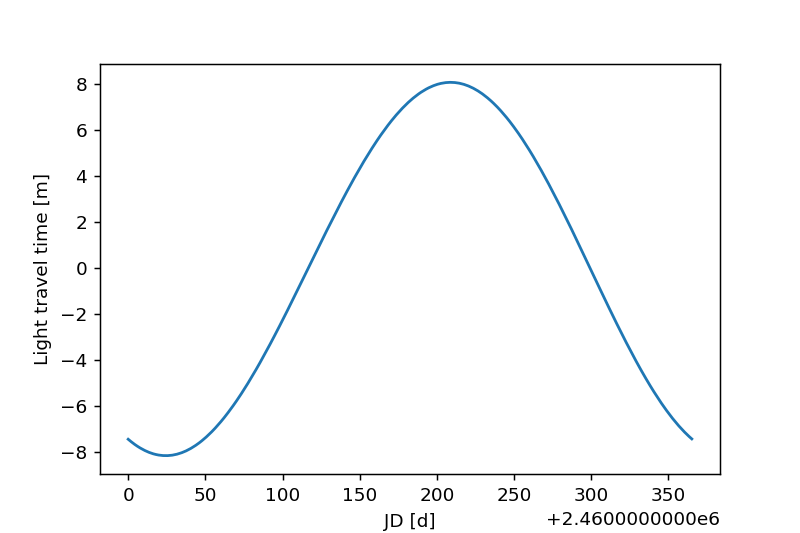

<SkyCoord (BarycentricMeanEcliptic: equinox=J2000.000): (lon, lat) in deg
    (358.75704042, -12.49065187)>

In [3]:
# T0: from the header of the first scientific frame 
# JD = 2457284.410320 / JD at start
# here we are taking 2nd column and converting in days, adding absolute value of the starting point (in julian date)
# taken from the fits images, and then add half of the exposure time, again in days
# our JD at start = 2459174.232668
jd = (sentinel_data[:,2]/1440.) + 2459174.232668 + sentinel_data[:,3]/86400./2. 

# however this number is in utc scale, which has discontinuities, and we want to convert in TDB
# this is why we use the function Time

from astropy.time import Time
#https://docs.astropy.org/en/stable/time/
tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) # location of the observatory

# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

# Conversion from JD-UTC to TDB
# tm.tdb[:5]
# BUT: the results would be in Earth barycentric system. This still not enough
# In order to move from the Earth BC to the Solar System BC 
# we have to correct for the "light travel time", i.e.,
# the time required by the light to travel between Earth 
# and the Solar System barycenter 

from astropy import coordinates as coord, units as u
target = coord.SkyCoord("00:15:36.79", "-11:56:17.75", unit=(u.hourangle, u.deg), frame='icrs')
ltt_bary = tm.light_travel_time(target)  
# careful: this is not hour angle, but the RA expressed in hour angles
# here we'll have to put the coordinates of our actual target


#print(' Light travel time in minutes:')
#print(ltt_bary.to_value(u.min))


# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target)  

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

target.transform_to(frame='barycentricmeanecliptic')


In [4]:
# BJD_TDB is given by the sum of the time at the Earth barycenter + the ligh travel time
# But note that "tm" and "ltt_bary" are NOT arrays but objects. 
# type(tm) -> astropy.time.core.Time
# type(ltt_bary) -> astropy.time.core.DeltaTime


# They are two different kinds of objects as well! According to the documentation, 
# the first one is converted to an array by using 
# tm.tdb.to_value('jd')
#
# The second one using
# ltt_bary.to_value(u.d)
#
bjd_tdb = tm.tdb.to_value('jd') + ltt_bary.to_value(u.d)
# the final result is the time of our observation expressed in julian days in the barycentric reference frame of the solar system


In [5]:
# you can double check here http://astroutils.astronomy.ohio-state.edu/time/
# and use the website to check whether we have correctly carried out the conversion
print('Input values for website:')
print(jd[:4])
print('Output value to be compared')
print(bjd_tdb[:4])

print('Compute the difference in seconds')
print((2457284.41680402 - 2457284.416803980)*86400)



Input values for website:
[2459174.23275481 2459174.23294925 2459174.23314369 2459174.23333814]
Output value to be compared
[2459174.23631939 2459174.23651382 2459174.23670825 2459174.23690267]
Compute the difference in seconds
0.0034600496292114258


<IPython.core.display.Javascript object>


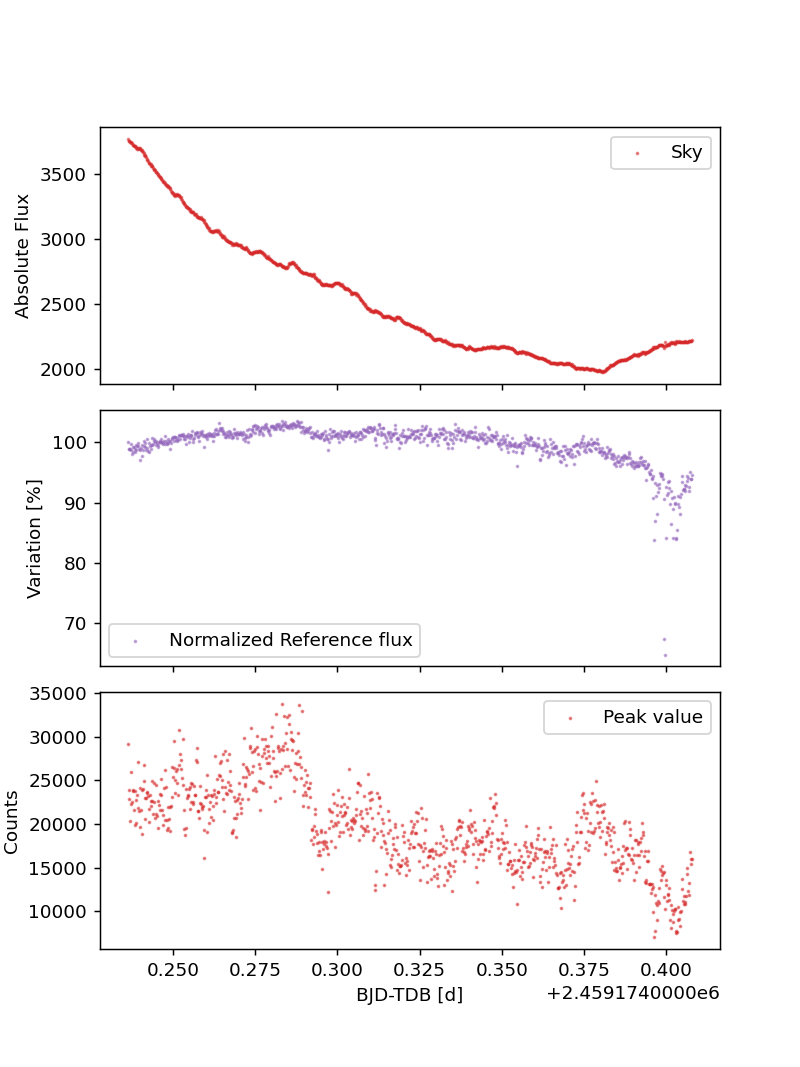

In [6]:
# Plot: "raw" light curve of target and reference

# 13: a2
# 15: r2
# 18: sky
# 19: abflux


fig, (ax2,ax3,ax4) = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
#fig, (ax2,ax3,ax4) = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)


#ax.scatter(bjd_tdb, sentinel_data2[:,12]/np.median(sentinel_data2[:,12]), c='C1', s=2, alpha=0.5, label='Target, Ap 90')
#ax.scatter(bjd_tdb, sentinel_data2[:,14]/np.median(sentinel_data2[:,14]), c='C2', s=2, alpha=0.5, label='Target, Ap 90')
#ax0.scatter(bjd_tdb, sentinel_data[:,12]/np.median(sentinel_data[:,12]), c='C1', s=2, alpha=0.5, label='Target, Ap 95')
#ax0.scatter(bjd_tdb, sentinel_data[:,14]/np.median(sentinel_data[:,14]), c='C2', s=2, alpha=0.5, label='Reference, Ap 95')
#ax1.scatter(bjd_tdb, sentinel_data[:,13]/np.median(sentinel_data[:,13]), c='C1', s=2, alpha=0.5, label='Target, Ap 99')
#ax1.scatter(bjd_tdb, sentinel_data[:,15]/np.median(sentinel_data[:,15]), c='C2', s=2, alpha=0.5, label='Target, Ap 99')

ax2.scatter(bjd_tdb, sentinel_data[:,18], c='C3', s=1, alpha=0.5, label='Sky')


ax3.scatter(bjd_tdb, sentinel_data[:,19], c='C4', s=1, alpha=0.5, label='Normalized Reference flux')
ax4.scatter(bjd_tdb, sentinel_data[:,11], c='C3', s=1, alpha=0.5, label='Peak value')

# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax4.set_xlabel('BJD-TDB [d]')

#ax.set_ylabel('Norm. abs. flux')
#ax0.set_ylabel('Norm. abs. flux')
#ax1.set_ylabel('Norm. abs. flux')
ax2.set_ylabel('Absolute Flux')
ax3.set_ylabel('Variation [%]')
ax4.set_ylabel('Counts')

#ax.legend()
#ax0.legend()
#ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()




# here there is something strange, since the sky bkg has a constant decrease
# but also both sources behave in a similar way

<IPython.core.display.Javascript object>


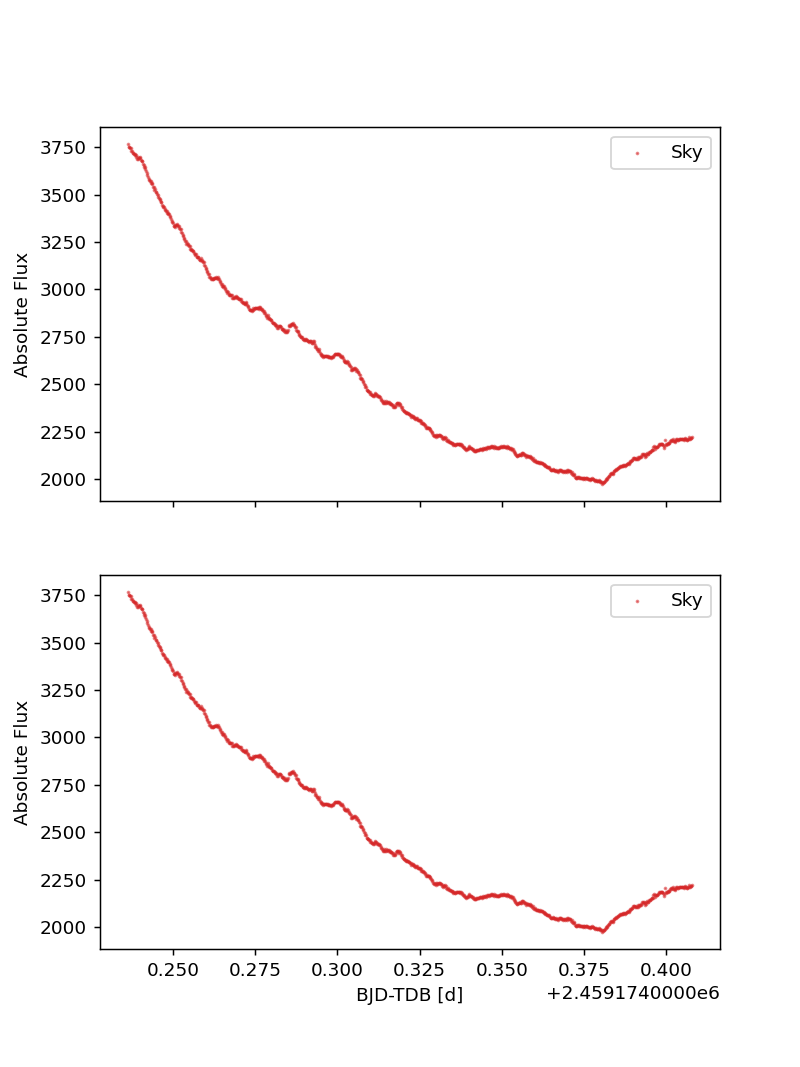

In [7]:
#sky plots
#fig, ax2 = plt.subplots(nrows=1, sharex=True, figsize=(6,6))
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,8))
ax1.scatter(bjd_tdb, sentinel_data[:,18], c='C3', s=1, alpha=0.5, label='Sky')
ax2.scatter(bjd_tdb, sentinel_data2[:,18], c='C3', s=1, alpha=0.5, label='Sky')

ax2.set_xlabel('BJD-TDB [d]')
ax1.set_ylabel('Absolute Flux')
ax2.set_ylabel('Absolute Flux')
ax1.legend()
ax2.legend()
plt.show()


<IPython.core.display.Javascript object>


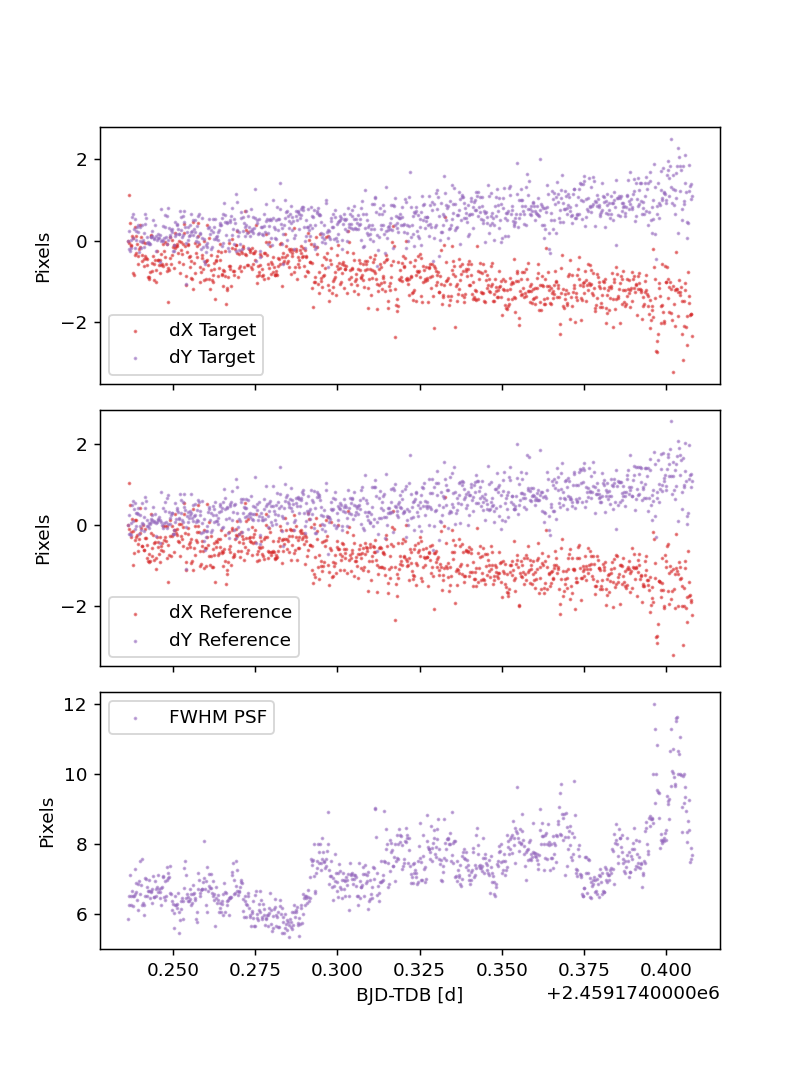

In [8]:
# Plot: "raw" light curve of target and reference

# 13: a2
# 15: r2
# 18: sky
# 19: abflux

# 13: a2
# 15: r2
# 18: sky
# 19: abflux

# 0: nf 
# 1: name
# 2: min
# 3: expt
# 4: x
# 5: y 
# 6: dx
# 7: dy
# 8: xr
# 9: yr
# 10: fw
# 11: peak
# 12: a1
# 13: a2
# 14: r1
# 15: r2
# 16: lc1
# 17: lc2
# 18: sky
# 19: abflux


#fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
fig, (ax2,ax3,ax4) = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

#ax1.scatter(bjd_tdb, sentinel_data[:,13]/np.median(sentinel_data[:,13]), c='C1', s=2, alpha=0.5, label='Target, Ap 99')
#ax1.scatter(bjd_tdb, sentinel_data[:,15]/np.median(sentinel_data[:,15]), c='C2', s=2, alpha=0.5, label='Reference, Ap 99')


ax2.scatter(bjd_tdb, sentinel_data[:,6], c='C3', s=1, alpha=0.5, label='dX Target')
ax2.scatter(bjd_tdb, sentinel_data[:,7], c='C4', s=1, alpha=0.5, label='dY Target')

ax3.scatter(bjd_tdb, sentinel_data[:,8]-sentinel_data[0,8], c='C3', s=1, alpha=0.5, label='dX Reference')
ax3.scatter(bjd_tdb, sentinel_data[:,9]-sentinel_data[0,9], c='C4', s=1, alpha=0.5, label='dY Reference')

ax4.scatter(bjd_tdb, sentinel_data[:,10], c='C4', s=1, alpha=0.5, label='FWHM PSF')

#ax3.scatter(bjd_tdb, sentinel_data[:,19], c='C4', s=1, alpha=0.5, label='Normalized Reference flux')
#ax4.scatter(bjd_tdb, sentinel_data[:,11], c='C3', s=1, alpha=0.5, label='Peak value')

# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax4.set_xlabel('BJD-TDB [d]')

#ax1.set_ylabel('Norm. abs. flux')
ax2.set_ylabel('Pixels')
ax3.set_ylabel('Pixels')
ax4.set_ylabel('Pixels')

#ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()




# reference and target move in the same way, this a nice check that nothing went wrong with the apparatus

<IPython.core.display.Javascript object>


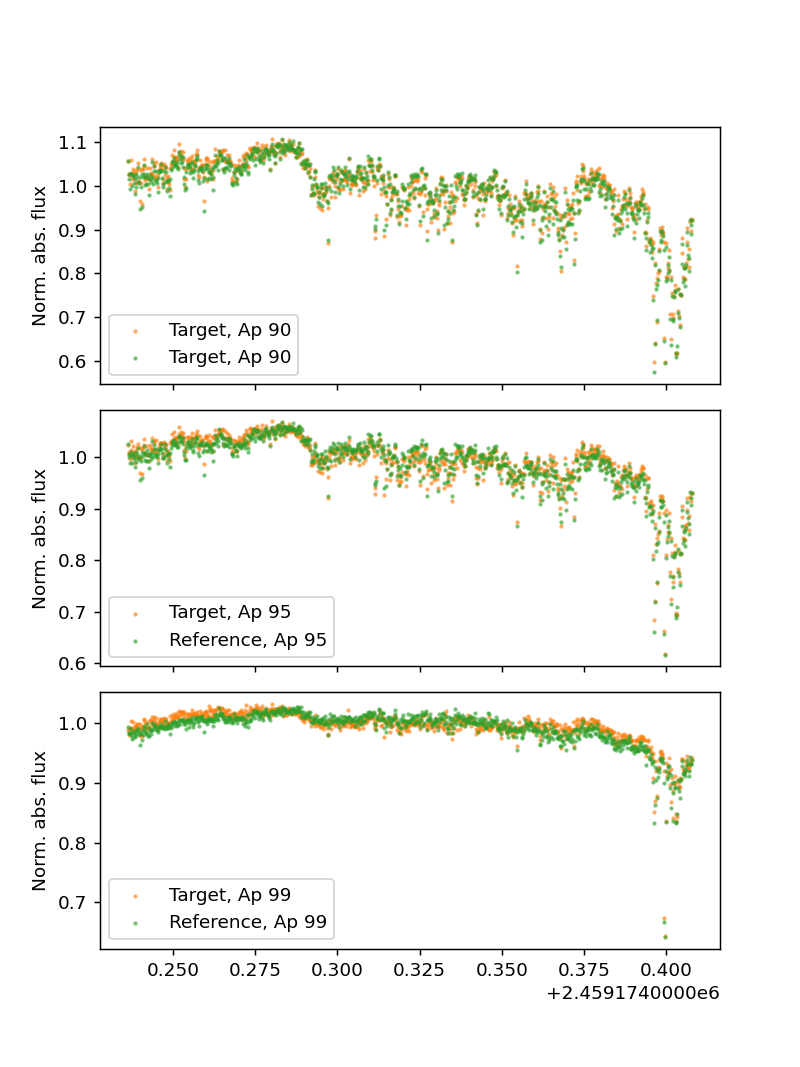

In [9]:
# Plot: light curve of target and reference

# 12: a1
# 13: a2
# 14: r1
# 15: r2
# 16: lc1
# 17: lc2


#fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6,8))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax0.scatter(bjd_tdb, sentinel_data2[:,12]/np.median(sentinel_data2[:,12]), c='C1', s=2, alpha=0.5, label='Target, Ap 90')
ax0.scatter(bjd_tdb, sentinel_data2[:,14]/np.median(sentinel_data2[:,14]), c='C2', s=2, alpha=0.5, label='Target, Ap 90')

ax1.scatter(bjd_tdb, sentinel_data[:,12]/np.median(sentinel_data[:,12]), c='C1', s=2, alpha=0.5, label='Target, Ap 95')
ax1.scatter(bjd_tdb, sentinel_data[:,14]/np.median(sentinel_data[:,14]), c='C2', s=2, alpha=0.5, label='Reference, Ap 95')

ax2.scatter(bjd_tdb, sentinel_data[:,13]/np.median(sentinel_data[:,13]), c='C1', s=2, alpha=0.5, label='Target, Ap 99')
ax2.scatter(bjd_tdb, sentinel_data[:,15]/np.median(sentinel_data[:,15]), c='C2', s=2, alpha=0.5, label='Reference, Ap 99')


#ax3.scatter(bjd_tdb, sentinel_data[:,16]/np.median(sentinel_data[:,16]), c='C3', s=2, alpha=0.5, label='Aperture #1')
#ax3.scatter(bjd_tdb, sentinel_data[:,17]/np.median(sentinel_data[:,17])-0.05, c='C4', s=2, alpha=0.5, label='Aperture #2, shifted')

ax0.set_ylabel('Norm. abs. flux')
ax1.set_ylabel('Norm. abs. flux')
ax2.set_ylabel('Norm. abs. flux')
#ax3.set_ylabel('Norm. abs. flux')




# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
#ax3.set_xlabel('BJD-TDB [d]')
#ax3.set_ylabel('Variation [%]')

ax0.legend()
ax1.legend()
ax2.legend()
#ax3.legend()
plt.show()

# the second aperture looks slightly better, less noisy
# the difference between apertures is only evident with differential photometry


<IPython.core.display.Javascript object>


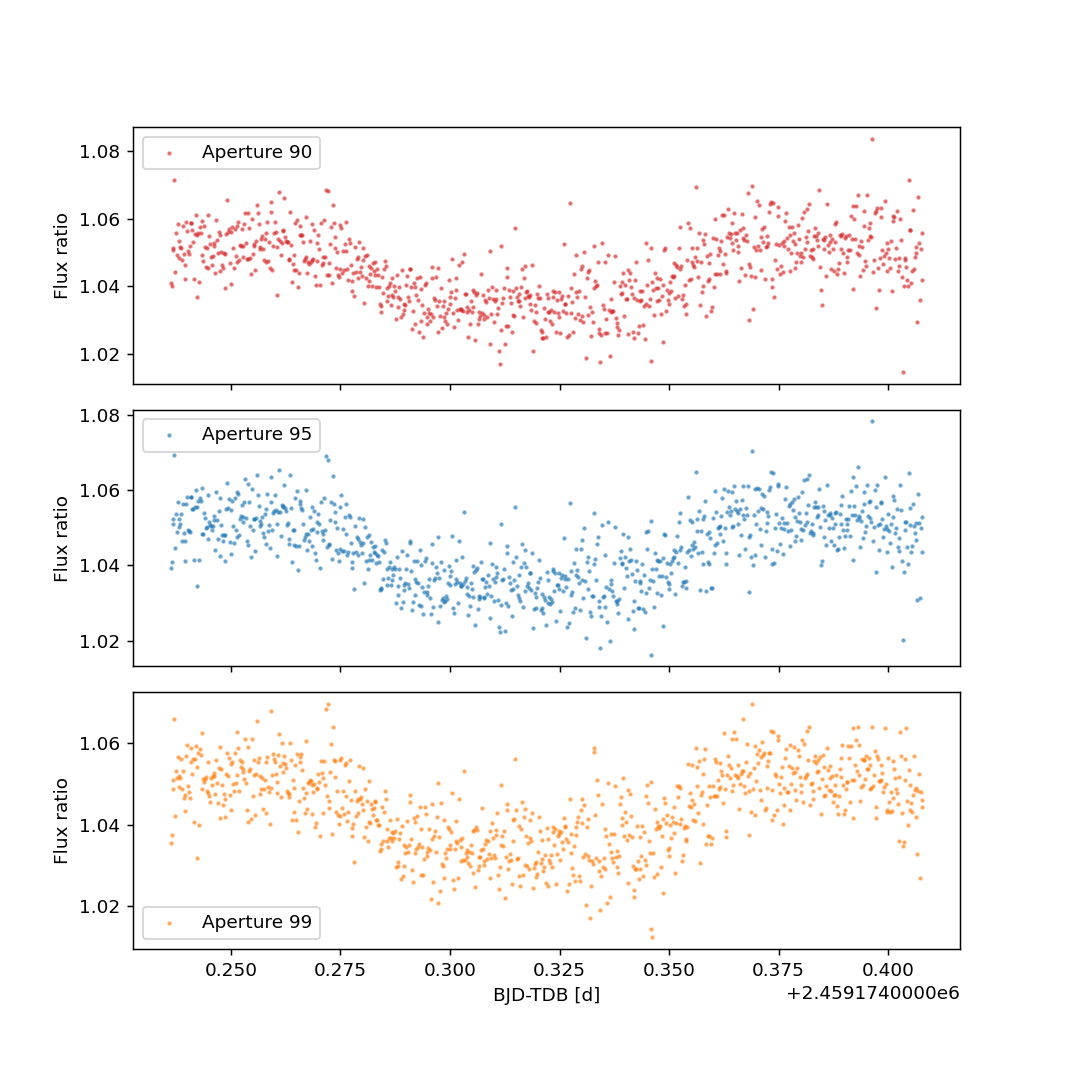

In [10]:
# Plot: ratio of target flux divided by the reference flux 

# Aperture #1
# 12: a1
# 14: r1
# 16: lc1 = a1/r1

# Aperture #2
# 13: a2
# 15: r2
# 17: lc2 = a2/r2

# For a better comparison, we devided by the median 
median_aperture0 = np.median(sentinel_data2[:,16])
median_aperture1 = np.median(sentinel_data[:,16])
median_aperture2 = np.median(sentinel_data[:,17])

fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(8,8))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

#ax1.scatter(bjd_tdb, sentinel_data[:,16] / median_aperture1, c='C0', s=2, alpha=0.5, label='Aperture #1')
#ax2.scatter(bjd_tdb, sentinel_data[:,17] / median_aperture2, c='C1', s=2, alpha=0.5, label='Aperture #2')

ax0.scatter(bjd_tdb, sentinel_data2[:,16] , c='C3', s=2, alpha=0.5, label='Aperture 90')
ax1.scatter(bjd_tdb, sentinel_data[:,16] , c='C0', s=2, alpha=0.5, label='Aperture 95')
ax2.scatter(bjd_tdb, sentinel_data[:,17] , c='C1', s=2, alpha=0.5, label='Aperture 99')



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax0.set_ylabel('Flux ratio')
ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('Flux ratio')

ax0.legend()
ax1.legend()
ax2.legend()
plt.show()



103.517


<IPython.core.display.Javascript object>


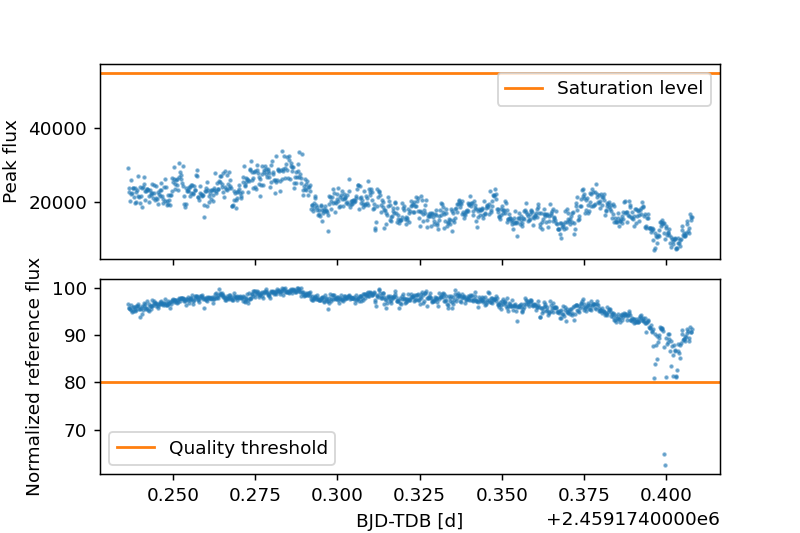

In [11]:
# Plot 1: Check if either the peak value of BOTH aperture is below the saturation level, 
# Plot 1: check if the reference star has a stable flux:

# 11: peak
# 19: abflux

ab_max = np.amax(sentinel_data[:,19])
print(ab_max)
#ab_max = 103.
ab_rescaled = sentinel_data[:,19]/ab_max * 100.00 

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,11], c='C0', s=2, alpha=0.5)
ax1.axhline(55000, c='C1', label='Saturation level')

ax2.scatter(bjd_tdb, ab_rescaled, c='C0', s=2, alpha=0.5)
ax2.axhline(80, c='C1', label='Quality threshold')



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Peak flux')
ax2.set_ylabel('Normalized reference flux')

ax1.legend()
ax2.legend()
plt.show()

quality_selection = (sentinel_data[:,11] < 55000) & (ab_rescaled > 80)

104.041


<IPython.core.display.Javascript object>


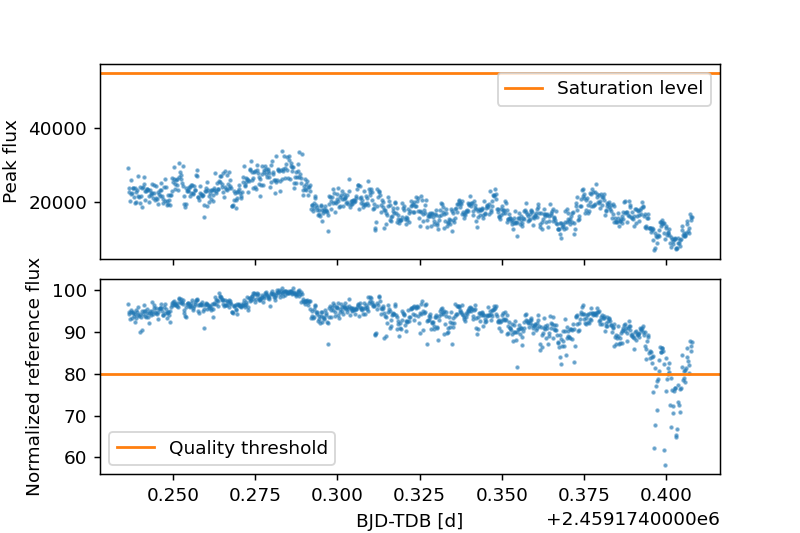

In [12]:
# same thing but with the other apertures

ab_max2 = np.amax(sentinel_data2[:,19])
print(ab_max2)
#ab_max = 103.
ab_rescaled2 = sentinel_data2[:,19]/ab_max * 100.00 

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data2[:,11], c='C0', s=2, alpha=0.5)
ax1.axhline(55000, c='C1', label='Saturation level')

ax2.scatter(bjd_tdb, ab_rescaled2, c='C0', s=2, alpha=0.5)
ax2.axhline(80, c='C1', label='Quality threshold')



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Peak flux')
ax2.set_ylabel('Normalized reference flux')

ax1.legend()
ax2.legend()
plt.show()

quality_selection2 = (sentinel_data2[:,11] < 55000) & (ab_rescaled2 > 80)

In [13]:
# Error computation
lc0_err =  sentinel_data2[:,16] * np.sqrt(  1./ sentinel_data2[:,12] +   1./ sentinel_data2[:,14]   )
lc1_err = sentinel_data[:,16] * np.sqrt(  1./ sentinel_data[:,12] +   1./ sentinel_data[:,14]   )
lc2_err = sentinel_data[:,17] * np.sqrt(  1./ sentinel_data[:,13] +   1./ sentinel_data[:,15]   )
# Is it correct? it may be, it may not.... 
# Check the error propagation, assuming the standard error for poisson counting...
print(lc1_err[:10])
print(lc2_err[:10])

[0.00219951 0.00222303 0.0022491  0.00225982 0.00227052 0.00222423
 0.00226321 0.00224023 0.00224908 0.00225317]
[0.0021439  0.00215821 0.00217575 0.00218009 0.0022059  0.00215707
 0.00219274 0.0021858  0.00218493 0.00217392]


In [14]:
# Saving to a file using the PyORBIT standard
# lightcurve normalization will be included in the model
# 
fileout = open('WASP44_TASTE_90.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection2]-2450000.0, sentinel_data2[quality_selection2,16], lc0_err[quality_selection2]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()


fileout = open('WASP44_TASTE_95.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,16], lc1_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()

fileout = open('WASP44_TASTE_99.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,17], lc2_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()

<IPython.core.display.Javascript object>


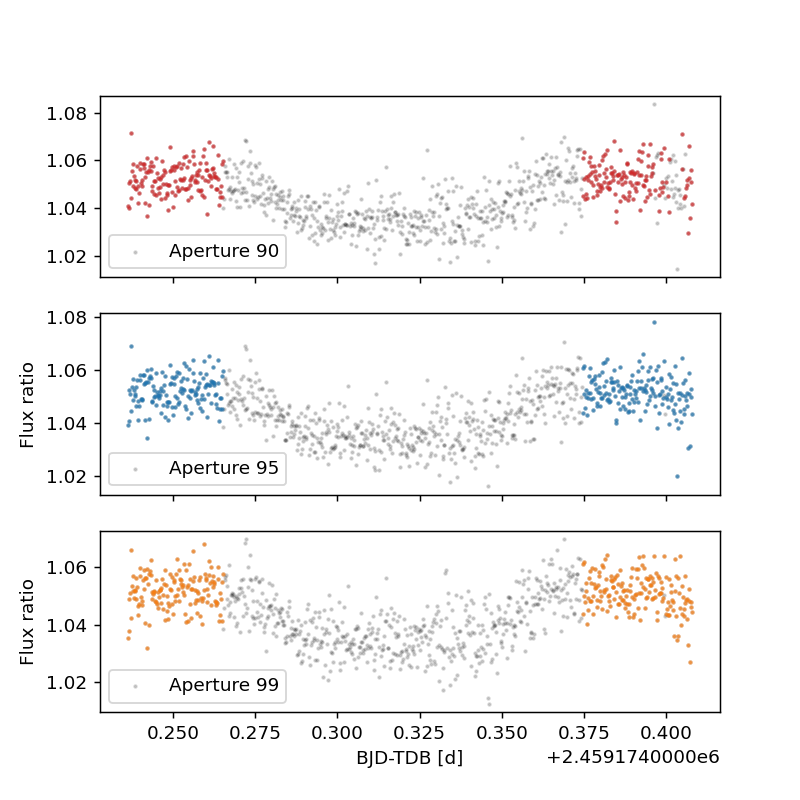

In [15]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6,6))

out_of_transit = ((bjd_tdb < 2459174.2652) | (bjd_tdb > 2459174.3744)) & quality_selection
out_of_transit2 = ((bjd_tdb < 2459174.2652) | (bjd_tdb > 2459174.3744)) & quality_selection2


ax0.scatter(bjd_tdb, sentinel_data2[:,16] , c='k', s=2, alpha=0.15, label='Aperture 90')
ax1.scatter(bjd_tdb, sentinel_data[:,16] , c='k', s=2, alpha=0.15, label='Aperture 95')
ax2.scatter(bjd_tdb, sentinel_data[:,17] , c='k', s=2, alpha=0.15, label='Aperture 99')

ax0.scatter(bjd_tdb[out_of_transit2], sentinel_data2[out_of_transit2,16] , c='C3', s=2, alpha=0.5)
ax1.scatter(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,16] , c='C0', s=2, alpha=0.5)
ax2.scatter(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,17] , c='C1', s=2, alpha=0.5)



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Flux ratio')
ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('Flux ratio')

ax0.legend()
ax1.legend()
ax2.legend()
plt.show()




[-1.19413252e-10  1.42643185e-07  7.22857787e+02]
[-7.97512616e-10  1.42583427e-07  4.82368943e+03]
[-8.97712963e-10  1.42487057e-07  5.42965440e+03]


/home/adri/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/adri/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/adri/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


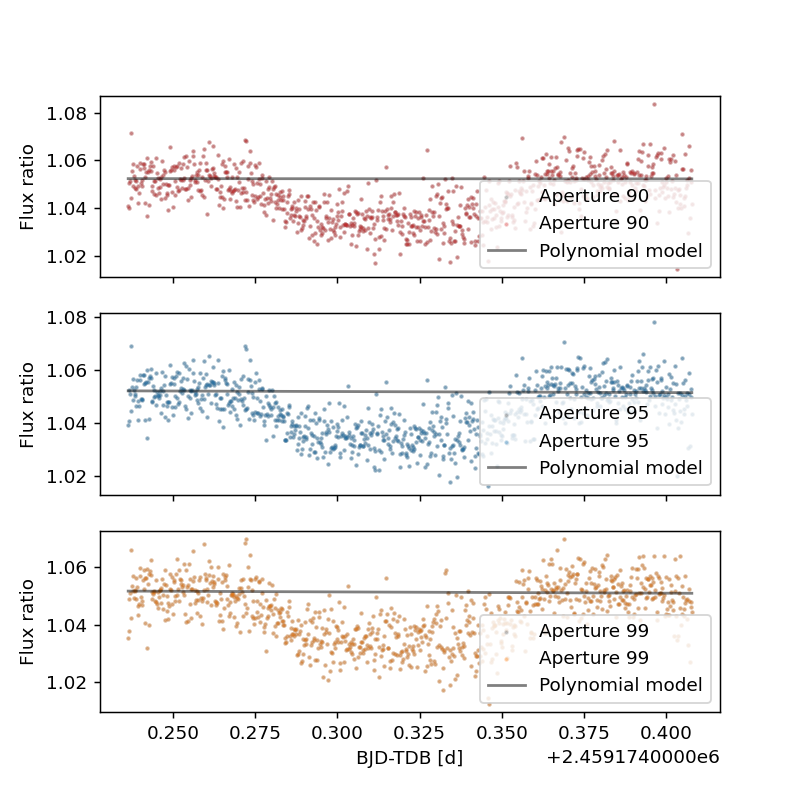

In [16]:

#https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
    
coeff_ap00 = np.polyfit(bjd_tdb[out_of_transit2], sentinel_data2[out_of_transit2,16], 2)
coeff_ap01 = np.polyfit(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,16], 2)
coeff_ap02 = np.polyfit(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,17], 2)
#ax^2 + bx + c
print(coeff_ap00)
print(coeff_ap01)
print(coeff_ap02)

poly_ap00 = np.polyval(coeff_ap00, bjd_tdb)
poly_ap01 = np.polyval(coeff_ap01, bjd_tdb)
poly_ap02 = np.polyval(coeff_ap02, bjd_tdb)



fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6,6))

ax0.scatter(bjd_tdb, sentinel_data2[:,16] , c='k', s=2, alpha=0.15, label='Aperture 90')
ax1.scatter(bjd_tdb, sentinel_data[:,16] , c='k', s=2, alpha=0.15, label='Aperture 95')
ax2.scatter(bjd_tdb, sentinel_data[:,17] , c='k', s=2, alpha=0.15, label='Aperture 99')

ax0.scatter(bjd_tdb, sentinel_data2[:,16] , c='C3', s=2, alpha=0.25, label='Aperture 90')
ax1.scatter(bjd_tdb, sentinel_data[:,16] , c='C0', s=2, alpha=0.25, label='Aperture 95')
ax2.scatter(bjd_tdb, sentinel_data[:,17] , c='C1', s=2, alpha=0.25, label='Aperture 99')

ax0.plot(bjd_tdb, poly_ap00, color='k', alpha=0.5, label='Polynomial model')
ax1.plot(bjd_tdb, poly_ap01, color='k', alpha=0.5, label='Polynomial model')
ax2.plot(bjd_tdb, poly_ap02 , color='k', alpha=0.5, label='Polynomial model')


# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax0.set_ylabel('Flux ratio')
ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('Flux ratio')

ax0.legend()
ax1.legend()
ax2.legend()
plt.show()




<IPython.core.display.Javascript object>


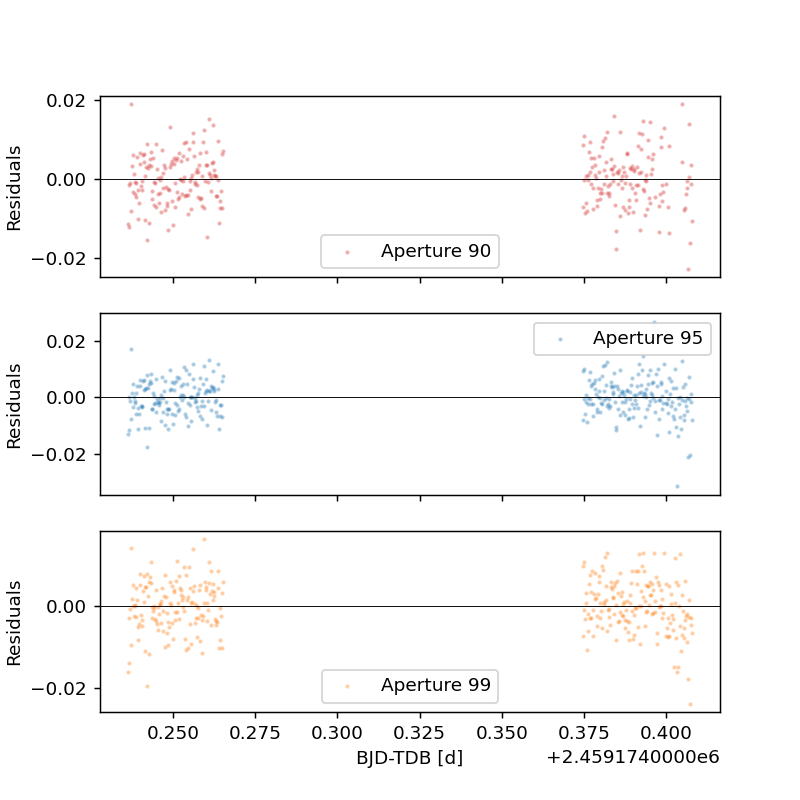

In [17]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6,6))

ax0.scatter(bjd_tdb[out_of_transit2], sentinel_data2[out_of_transit2,16]-poly_ap00[out_of_transit2] , c='C3', s=2, alpha=0.25, label='Aperture 90')
ax0.axhline(linewidth=0.5, color='black')
ax1.scatter(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,16]-poly_ap01[out_of_transit] , c='C0', s=2, alpha=0.25, label='Aperture 95')
ax1.axhline(linewidth=0.5, color='black')
ax2.scatter(bjd_tdb[out_of_transit], sentinel_data[out_of_transit,17]-poly_ap02[out_of_transit] , c='C1', s=2, alpha=0.25, label='Aperture 99')
ax2.axhline(linewidth=0.5, color='black')
ax2.set_xlabel('BJD-TDB [d]')

ax0.set_ylabel('Residuals')
ax1.set_ylabel("Residuals")
ax2.set_ylabel('Residuals')

ax0.legend()
ax1.legend()
ax2.legend()
plt.show()

In [18]:
detrended_ap00 = sentinel_data2[:,16]/poly_ap00
detrended_ap01 = sentinel_data[:,16]/poly_ap01
detrended_ap02 = sentinel_data[:,17]/poly_ap02

print(np.std(detrended_ap00[out_of_transit2]))
print(np.std(detrended_ap01[out_of_transit]))
print(np.std(detrended_ap02[out_of_transit]))

std90 = np.std(detrended_ap00[out_of_transit2])
std95 = np.std(detrended_ap01[out_of_transit])
std99 = np.std(detrended_ap02[out_of_transit])
N = int(len(sentinel_data[:,17]))
errvec = np.ones(N, float)*std99


# standard deviation of the out-of-transit flux
# the lowest one is associated to the less noisy case: light curve extraction worked better in that case

0.006332003255107664
0.006097842333661236
0.005915876356087341


<IPython.core.display.Javascript object>


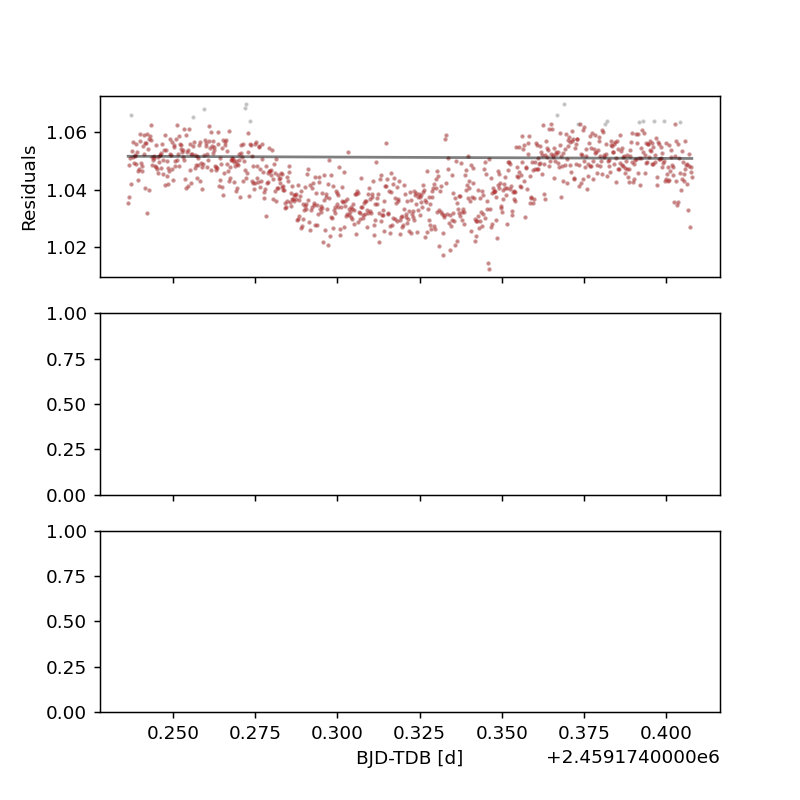

In [19]:
outliers = ((sentinel_data[:,17]-poly_ap02) < 2*std99)
#print(outliers)

fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6,6))
ax0.plot(bjd_tdb, poly_ap02, color='k', alpha=0.5, label='Polynomial model')
ax0.scatter(bjd_tdb, sentinel_data[:,17] , c='k', s=2, alpha=0.15, label='Aperture 90')
ax0.scatter(bjd_tdb[outliers], sentinel_data[outliers,17], c='C3', s=2, alpha=0.25, label='Aperture 90')

ax2.set_xlabel('BJD-TDB [d]')

ax0.set_ylabel('Residuals')
plt.show()


In [20]:
fileout = open('WASP44_TASTE_PyORBIT.dat', 'w')
for b, v, e in zip(bjd_tdb[quality_selection], 
                   sentinel_data[quality_selection,17],
                   lc2_err[quality_selection]):
    fileout.write('{0:16f} {1:12f} {2:12f} 0 \n'.format(b,v,e))
fileout.close()